## SQL Generation Agent with DuckDB

In [1]:
import os

In [2]:
os.environ["LANGCHAIN_API_KEY"] = os.environ.get("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = os.environ.get("LANGCHAIN_TRACING_V2")
os.environ["OPENAI_API_KEY"] = os.environ.get("OPENAI_API_KEY")


### DuckDB Loader Example

In [3]:
from langchain_community.document_loaders import DuckDBLoader

In [4]:
file_path = "data/netflix_titles.csv"
loader = DuckDBLoader(f"SELECT * FROM read_csv_auto('{file_path}') LIMIT 10")

In [5]:
data = loader.load()

In [6]:
data

[Document(metadata={}, page_content='show_id: s1\ntype: Movie\ntitle: Dick Johnson Is Dead\ndirector: Kirsten Johnson\ncast: None\ncountry: United States\ndate_added: September 25, 2021\nrelease_year: 2020\nrating: PG-13\nduration: 90 min\nlisted_in: Documentaries\ndescription: As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable.'),
 Document(metadata={}, page_content='show_id: s2\ntype: TV Show\ntitle: Blood & Water\ndirector: None\ncast: Ama Qamata, Khosi Ngema, Gail Mabalane, Thabang Molaba, Dillon Windvogel, Natasha Thahane, Arno Greeff, Xolile Tshabalala, Getmore Sithole, Cindy Mahlangu, Ryle De Morny, Greteli Fincham, Sello Maake Ka-Ncube, Odwa Gwanya, Mekaila Mathys, Sandi Schultz, Duane Williams, Shamilla Miller, Patrick Mofokeng\ncountry: South Africa\ndate_added: September 24, 2021\nrelease_year: 2021\nrating: TV-MA\nduration: 2 Seasons\nlisted_in: International TV Shows, TV Dr

### Build the SQL Generation Agent

In [7]:
from typing_extensions import TypedDict


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

In [8]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

In [9]:
from langchain import hub
query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")
assert len(query_prompt_template.messages) == 1
query_prompt_template.messages[0].pretty_print()


================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}


### Define Write Query

In [10]:
from typing_extensions import Annotated


class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": "duckdb",
            "top_k": 10,
            "table_info": f"read_csv_auto('{file_path}')",
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

In [11]:
sql_query = write_query({"question": "How many shows are there?"})
sql_query

{'query': "SELECT COUNT(*) FROM read_csv_auto('data/netflix_titles.csv')"}

In [12]:
def execute_query(state: State):
    """Execute SQL query."""
    data = DuckDBLoader(state["query"]).load()
    return {'result': data}

In [44]:
execute_query(sql_query)

{'result': [Document(metadata={}, page_content='count_star(): 8807')]}

In [45]:
sql_query = write_query({"question": "Can you get the total shows per director, and sort by total shows in desending order?"})
print(sql_query)
execute_query(sql_query)

{'query': "SELECT director, COUNT(*) as total_shows \nFROM read_csv_auto('data/netflix_titles.csv') \nWHERE director IS NOT NULL\nGROUP BY director \nORDER BY total_shows DESC \nLIMIT 10;"}


{'result': [Document(metadata={}, page_content='director: Rajiv Chilaka\ntotal_shows: 19'),
  Document(metadata={}, page_content='director: Raúl Campos, Jan Suter\ntotal_shows: 18'),
  Document(metadata={}, page_content='director: Suhas Kadav\ntotal_shows: 16'),
  Document(metadata={}, page_content='director: Marcus Raboy\ntotal_shows: 16'),
  Document(metadata={}, page_content='director: Jay Karas\ntotal_shows: 14'),
  Document(metadata={}, page_content='director: Cathy Garcia-Molina\ntotal_shows: 13'),
  Document(metadata={}, page_content='director: Youssef Chahine\ntotal_shows: 12'),
  Document(metadata={}, page_content='director: Jay Chapman\ntotal_shows: 12'),
  Document(metadata={}, page_content='director: Martin Scorsese\ntotal_shows: 12'),
  Document(metadata={}, page_content='director: Steven Spielberg\ntotal_shows: 11')]}

In [14]:
sql_query = write_query({"question": "Can you get number of shows start with letter D?"})
print(sql_query)
execute_query(sql_query)

{'query': "SELECT COUNT(*) \nFROM read_csv_auto('data/netflix_titles.csv') \nWHERE title LIKE 'D%';"}


{'result': [Document(metadata={}, page_content='count_star(): 375')]}

In [13]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

In [14]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)

graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

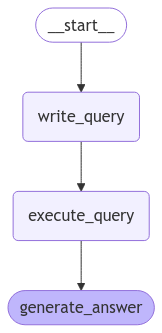

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [50]:
for step in graph.stream(
    {"question": "Can you get the total shows per director, and sort by total shows in desending order for the top 3 director?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': "SELECT director, COUNT(*) as total_shows \nFROM read_csv_auto('data/netflix_titles.csv') \nWHERE director IS NOT NULL \nGROUP BY director \nORDER BY total_shows DESC \nLIMIT 3;"}}
{'execute_query': {'result': [Document(metadata={}, page_content='director: Rajiv Chilaka\ntotal_shows: 19'), Document(metadata={}, page_content='director: Raúl Campos, Jan Suter\ntotal_shows: 18'), Document(metadata={}, page_content='director: Suhas Kadav\ntotal_shows: 16')]}}
{'generate_answer': {'answer': 'The total shows per director, sorted by total shows in descending order for the top 3 directors, are as follows:\n\n1. Rajiv Chilaka - 19 shows\n2. Raúl Campos, Jan Suter - 18 shows\n3. Suhas Kadav - 16 shows'}}


In [16]:
for step in graph.stream(
    {"question": "Can you get number of shows start with letter D?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': "SELECT COUNT(*) FROM read_csv_auto('data/netflix_titles.csv') WHERE title LIKE 'D%';"}}
{'execute_query': {'result': [Document(metadata={}, page_content='count_star(): 375')]}}
{'generate_answer': {'answer': 'There are 375 shows that start with the letter D.'}}


In [ ]:
for step in graph.stream(
    {"question": "Can you get number of shows start with letter D?"}, stream_mode="updates"
):
    print(step)

In [18]:
for step in graph.stream(
    {"question": "Can you get the how many years between each show director Rajiv Chilaka produced, sort by release years?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': "SELECT title, release_year, release_year - LAG(release_year) OVER (ORDER BY release_year) AS years_between_releases\nFROM read_csv_auto('data/netflix_titles.csv')\nWHERE director = 'Rajiv Chilaka'\nORDER BY release_year\nLIMIT 10;"}}
{'execute_query': {'result': [Document(metadata={}, page_content='title: Chhota Bheem & Ganesh\nrelease_year: 2009\nyears_between_releases: None'), Document(metadata={}, page_content='title: Chhota Bheem aur Krishna\nrelease_year: 2009\nyears_between_releases: 0'), Document(metadata={}, page_content='title: Chhota Bheem & Krishna: Pataliputra- City of the Dead\nrelease_year: 2010\nyears_between_releases: 1'), Document(metadata={}, page_content='title: Chhota Bheem: Bheem vs Aliens\nrelease_year: 2010\nyears_between_releases: 0'), Document(metadata={}, page_content='title: Chhota Bheem & Krishna: Mayanagari\nrelease_year: 2011\nyears_between_releases: 1'), Document(metadata={}, page_content='title: Chhota Bheem: Journey to Petra\n